In [1]:
!pip install pandas-datareader
!pip install numpy
!pip install pandas
!pip install pandas_datareader
!pip install plotly

In [2]:
import math
from pandas_datareader import data
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
import itertools
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from arch import arch_model
plt.style.use('fivethirtyeight')
import datetime
#from sklearn.preprocessing import MinMaxScaler
#from keras.models import Sequential
#from keras.layers import Dense, LSTM

ModuleNotFoundError: No module named 'pandas_datareader'

In [136]:
yfin.pdr_override()

gspc = pdr.get_data_yahoo('NVDA', start='2015-01-01', end='2024-04-15')
avgspc = gspc.resample('M').mean()
avgspc.columns = ['AvgOpen', 'AvgHigh', 'AvgLow', 'AvgClose', 'AvgAdjClose', 'AvgVolume']

print(avgspc)


[*********************100%%**********************]  1 of 1 completed

               AvgOpen     AvgHigh      AvgLow    AvgClose  AvgAdjClose  \
Date                                                                      
2015-01-31    4.977500    5.033375    4.903125    4.961500     4.764399   
2015-02-28    5.340789    5.392368    5.293553    5.360789     5.152142   
2015-03-31    5.602045    5.667500    5.532841    5.604091     5.402184   
2015-04-30    5.506786    5.575357    5.455000    5.532143     5.332827   
2015-05-31    5.353750    5.429250    5.310500    5.371875     5.187853   
...                ...         ...         ...         ...          ...   
2023-12-31  479.873997  485.634999  474.148502  480.704999   480.678395   
2024-01-31  558.821426  568.233811  551.967619  562.591904   562.565517   
2024-02-29  724.294501  736.888498  710.367502  725.504498   725.470468   
2024-03-31  893.993994  913.450995  873.600992  894.425497   894.421570   
2024-04-30  881.689996  896.587000  864.948999  881.020001   881.020001   

               AvgVolume

In [137]:
returns = 100 * avgspc.AvgClose.pct_change().dropna()

Text(0.5, 1.0, 'GSPC Returns')

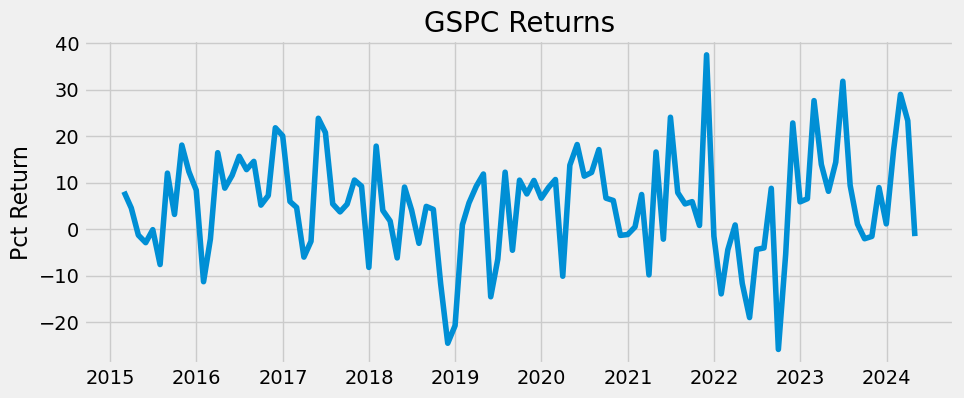

In [138]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('GSPC Returns', fontsize=20)

/Users/Andrew/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


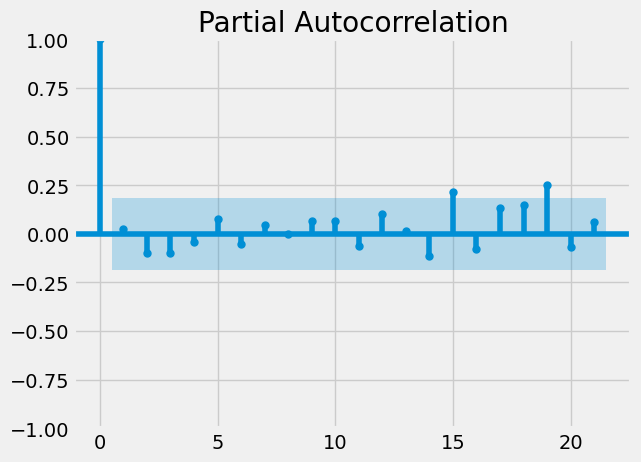

In [139]:
plot_pacf(returns**2)
plt.show()

In [140]:
def select_arch_order(data, max_p, max_q):
    best_aic = np.inf
    best_order = None
    
    # Generate all possible combinations of p and q
    orders = list(itertools.product(range(1, max_p + 1), range(1, max_q + 1)))
    
    for p, q in orders:
        model = arch_model(data, mean='Zero', vol='ARCH', p=p, q=q)
        model_fit = model.fit(disp='off')
        aic = model_fit.aic
        
        if aic < best_aic:
            best_aic = aic
            best_order = (p, q)
    
    return best_order

In [141]:
select_arch_order(returns, 5, 5)

(1, 1)

In [142]:
model = arch_model(returns, p=1, q=1)

In [143]:
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 442.58178954236445
Iteration:      2,   Func. Count:     12,   Neg. LLF: 424.3925651896743
Iteration:      3,   Func. Count:     17,   Neg. LLF: 423.9160445438918
Iteration:      4,   Func. Count:     22,   Neg. LLF: 423.8565530498974
Iteration:      5,   Func. Count:     27,   Neg. LLF: 423.84784034996676
Iteration:      6,   Func. Count:     32,   Neg. LLF: 423.8477336096994
Iteration:      7,   Func. Count:     36,   Neg. LLF: 423.8477338779405
Optimization terminated successfully    (Exit mode 0)
            Current function value: 423.8477336096994
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               AvgClose   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -423.848
Distribution:                  Normal   AIC:                           855.695
Method:            Maximum Likelihood   BIC:                           866.534
                                        No. Observations:                  111
Date:                Mon, Apr 15 2024   Df Residuals:                      110
Time:                        14:13:56   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             5.3840      1.012      5.320  1.035e-07 [  3.401,  7.367]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.9581      3.320      0.289      0.773      [ -5.549,  7.465]
alpha[1]       0.0000  3.675e-02      0.000      1.000 [-7.202e-02,7.202e-02]
beta[1]        1.0000  5.309e-02     18.836  3.814e-79      [  0.896,  1.104]
=============================================================================

Covariance estimator: robust
"""

In [144]:
rolling_predictions = []
test_size = 12

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp = 'off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [145]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-12:])
ratio = returns[-12:]/rolling_predictions

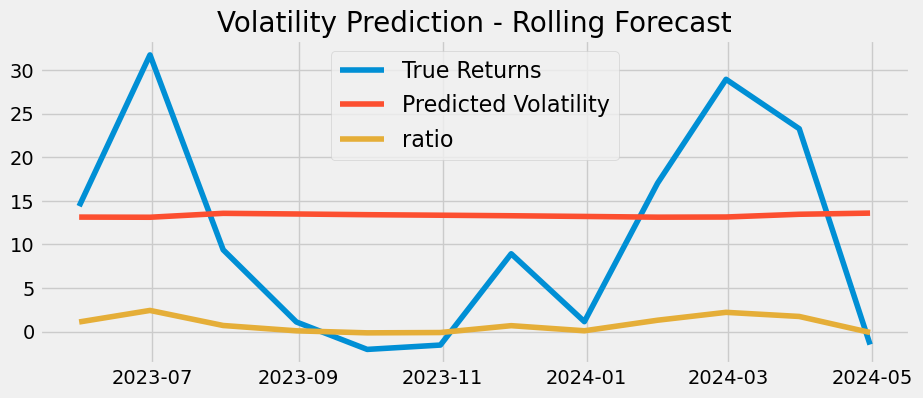

In [146]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-12:])
preds, = plt.plot(rolling_predictions)
ratio, = plt.plot(ratio)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility', 'ratio'], fontsize=16)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 months')

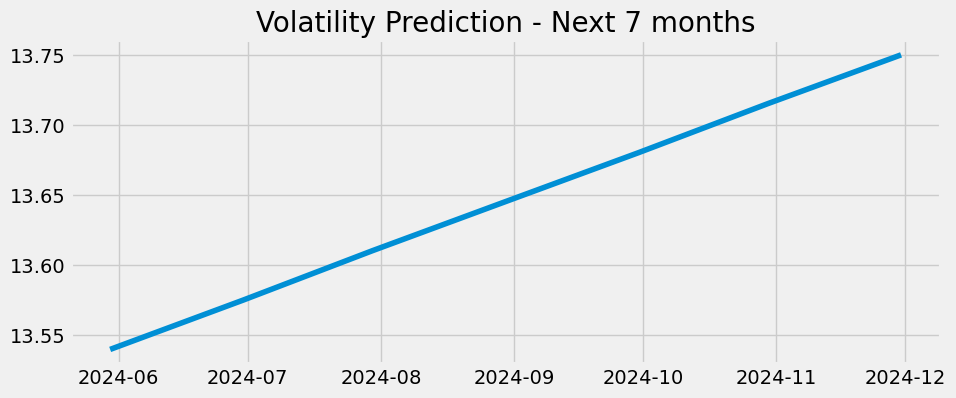

In [147]:
train = returns
model = arch_model(train, p=1, q=1)
model_fit = model.fit(disp='off')

pred = model_fit.forecast(horizon=7)
#future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
future_dates = [returns.index[-1] + relativedelta(months=i) for i in range(1, 8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 months', fontsize=20)

In [61]:
pred_df = pd.DataFrame(pred)

In [64]:
# Specify the file path and name
file_path = 'prediction.xlsx'

my_df = pd.DataFrame(rolling_predictions)

# Export the DataFrame
my_df.to_excel(file_path, index = True, engine='openpyxl')
